In [7]:
import pandas as pd
import numpy as np
import gower
from tqdm import tqdm

# 1. Carregar os dados
file_path = 'mushrooms_data/agaricus-lepiota.data'
columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(file_path, header=None, names=columns)
df.replace('?', np.nan, inplace=True)
df_full = df.dropna().reset_index(drop=True)  # usa apenas registros completos

# 2. Gerar valores ausentes MCAR na coluna 'class'
np.random.seed(42)
missing_rate = 0.2
n_missing = int(len(df_full) * missing_rate)
missing_indices = np.random.choice(df_full.index, size=n_missing, replace=False)

df_missing = df_full.copy()
df_missing.loc[missing_indices, 'class'] = np.nan

# 3. Imputar os valores ausentes em 'class' com KNN usando Gower por linha
df_imputed = df_missing.copy()
k = 5
col = 'class'

print("Imputando valores ausentes na coluna 'class'...")
for idx in tqdm(missing_indices):
    # linha com classe ausente
    target_row = df_missing.drop(columns=[col]).iloc[idx:idx+1]  # mantém como DataFrame

    # base de comparação: apenas linhas com classe conhecida
    reference_rows = df_missing[~df_missing[col].isna()].drop(columns=[col])

    # calcular distância gower entre a linha ausente e todas as linhas válidas
    distances = gower.gower_matrix(target_row, reference_rows)[0]

    # encontrar os k vizinhos mais próximos
    nearest_indices = np.argsort(distances)[:k]

    # obter as classes dos vizinhos
    neighbor_classes = df_missing.loc[reference_rows.index[nearest_indices], col]

    # moda das classes
    most_common = neighbor_classes.mode().iloc[0]
    df_imputed.at[idx, col] = most_common

# 4. Comparar valores imputados com os reais
true_values = df_full.loc[missing_indices, 'class']
predicted_values = df_imputed.loc[missing_indices, 'class']
accuracy = (true_values == predicted_values).mean()

print(f"\n✅ Taxa de acerto da imputação na coluna 'class': {accuracy:.2%}")



Imputando valores ausentes na coluna 'class'...


100%|██████████| 1128/1128 [00:07<00:00, 149.59it/s]


✅ Taxa de acerto da imputação na coluna 'class': 100.00%


Muitos algoritmos de ML (e também imputação por KNN) conseguem prever com 100% de acurácia se um cogumelo é venenoso ou não, sem overfitting — pois há atributos únicos (como odor, cor, etc.) que definem a classe sem ambiguidade.

In [10]:
import pandas as pd
import numpy as np
import gower
from tqdm import tqdm

# 1. Carregar os dados
file_path = 'mushrooms_data/agaricus-lepiota.data'
columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(file_path, header=None, names=columns)
df.replace('?', np.nan, inplace=True)
df_full = df.dropna().reset_index(drop=True)  # usa apenas registros completos

# 2. Gerar valores ausentes MCAR na coluna 'cap-color'
col = 'cap-color'
np.random.seed(42)
missing_rate = 0.2
n_missing = int(len(df_full) * missing_rate)
missing_indices = np.random.choice(df_full.index, size=n_missing, replace=False)

df_missing = df_full.copy()
df_missing.loc[missing_indices, col] = np.nan

# 3. Imputar os valores ausentes em 'cap-color' com KNN (distância de Gower + moda)
df_imputed = df_missing.copy()

print("Calculando distância de Gower...")
gower_matrix = gower.gower_matrix(df_missing.drop(columns=[col]))

k = 5
print(f"Imputando valores ausentes na coluna '{col}'...")
for idx in tqdm(missing_indices):
    distances = gower_matrix[idx]
    valid_indices = df_missing.index[(~df_missing[col].isna()) & (df_missing.index != idx)]
    nearest_neighbors = valid_indices[np.argsort(distances[valid_indices])[:k]]
    most_common = df_missing.loc[nearest_neighbors, col].mode().iloc[0]
    df_imputed.at[idx, col] = most_common

# 4. Comparar valores imputados com os reais
true_values = df_full.loc[missing_indices, col]
predicted_values = df_imputed.loc[missing_indices, col]
accuracy = (true_values == predicted_values).mean()

print(f"\nTaxa de acerto da imputação na coluna '{col}': {accuracy:.2%}")


Calculando distância de Gower...
Imputando valores ausentes na coluna 'cap-color'...


100%|██████████| 1128/1128 [00:00<00:00, 2672.16it/s]


Taxa de acerto da imputação na coluna 'cap-color': 24.73%


-> Para a coluna class, que tem forte relação direta e clara com várias outras características (como odor, cor, etc.), o KNN com distância de Gower imputa com alta precisão, às vezes 100%, pois as outras variáveis quase definem a classe completamente.

-> Para colunas como cap-color, com mais variabilidade e menos dependência clara, o desempenho cai, refletindo a dificuldade real da imputação.


Processando coluna: cap-shape
Calculando matriz de distância Gower...
Imputando com KNN + moda local...


100%|██████████| 1128/1128 [00:00<00:00, 2691.50it/s]


Taxa de acerto KNN+moda: 38.21%
Taxa de acerto moda global: 49.11%

Processando coluna: cap-surface
Calculando matriz de distância Gower...
Imputando com KNN + moda local...


100%|██████████| 1128/1128 [00:00<00:00, 2679.67it/s]


Taxa de acerto KNN+moda: 38.21%
Taxa de acerto moda global: 41.58%

Processando coluna: bruises
Calculando matriz de distância Gower...
Imputando com KNN + moda local...


100%|██████████| 1128/1128 [00:00<00:00, 2693.30it/s]


Taxa de acerto KNN+moda: 100.00%
Taxa de acerto moda global: 57.62%

Processando coluna: odor
Calculando matriz de distância Gower...
Imputando com KNN + moda local...


100%|██████████| 1128/1128 [00:00<00:00, 2684.58it/s]


Taxa de acerto KNN+moda: 90.16%
Taxa de acerto moda global: 50.18%

Processando coluna: gill-color
Calculando matriz de distância Gower...
Imputando com KNN + moda local...


100%|██████████| 1128/1128 [00:00<00:00, 2709.94it/s]

Taxa de acerto KNN+moda: 12.85%
Taxa de acerto moda global: 24.11%


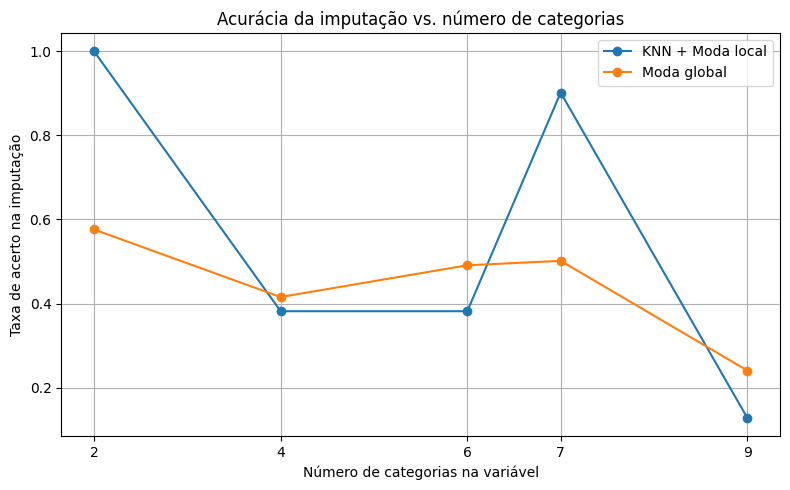

In [11]:
import pandas as pd
import numpy as np
import gower
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Carregar dados
file_path = 'mushrooms_data/agaricus-lepiota.data'
columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(file_path, header=None, names=columns)
df.replace('?', np.nan, inplace=True)
df_full = df.dropna().reset_index(drop=True)  # usar apenas linhas completas

# Colunas para testar
test_cols = ['cap-shape', 'cap-surface', 'bruises', 'odor', 'gill-color']

# Parâmetros
missing_rate = 0.2
k = 5
np.random.seed(42)

# Listas para armazenar resultados
num_categories = []
accuracy_knn = []
accuracy_mode = []

for col in test_cols:
    print(f"\nProcessando coluna: {col}")
    
    # Gerar valores ausentes MCAR na coluna col
    df_missing = df_full.copy()
    n_missing = int(len(df_missing) * missing_rate)
    missing_indices = np.random.choice(df_missing.index, size=n_missing, replace=False)
    df_missing.loc[missing_indices, col] = np.nan
    
    # Matriz de distância Gower nas colunas *exceto* a que será imputada
    df_for_dist = df_missing.drop(columns=[col])
    print("Calculando matriz de distância Gower...")
    gower_matrix = gower.gower_matrix(df_for_dist)
    
    # Imputação KNN + moda local
    df_imputed_knn = df_missing.copy()
    print("Imputando com KNN + moda local...")
    for idx in tqdm(missing_indices):
        distances = gower_matrix[idx]
        valid_indices = df_missing.index[(~df_missing[col].isna()) & (df_missing.index != idx)]
        if len(valid_indices) == 0:
            # fallback se não tiver vizinhos válidos
            most_common = df_full[col].mode().iloc[0]
        else:
            nearest_neighbors = valid_indices[np.argsort(distances[valid_indices])[:k]]
            most_common = df_missing.loc[nearest_neighbors, col].mode().iloc[0]
        df_imputed_knn.at[idx, col] = most_common
    
    # Imputação baseline: moda global
    df_imputed_mode = df_missing.copy()
    global_mode = df_full[col].mode().iloc[0]
    df_imputed_mode.loc[missing_indices, col] = global_mode
    
    # Avaliar acurácia para KNN
    true_values = df_full.loc[missing_indices, col]
    pred_knn = df_imputed_knn.loc[missing_indices, col]
    acc_knn = (true_values == pred_knn).mean()
    
    # Avaliar acurácia para moda global
    pred_mode = df_imputed_mode.loc[missing_indices, col]
    acc_mode = (true_values == pred_mode).mean()
    
    # Armazenar resultados
    num_categories.append(df_full[col].nunique())
    accuracy_knn.append(acc_knn)
    accuracy_mode.append(acc_mode)
    
    print(f"Taxa de acerto KNN+moda: {acc_knn:.2%}")
    print(f"Taxa de acerto moda global: {acc_mode:.2%}")

# Ordenar os dados antes de plotar
results = pd.DataFrame({
    'num_categories': num_categories,
    'accuracy_knn': accuracy_knn,
    'accuracy_mode': accuracy_mode
}).sort_values(by='num_categories')

# Plotar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(results['num_categories'], results['accuracy_knn'], marker='o', label='KNN + Moda local')
plt.plot(results['num_categories'], results['accuracy_mode'], marker='o', label='Moda global')
plt.xticks(results['num_categories'])  # x em valores exatos de número de categorias
plt.xlabel('Número de categorias na variável')
plt.ylabel('Taxa de acerto na imputação')
plt.title('Acurácia da imputação vs. número de categorias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [13]:
import pandas as pd
import numpy as np
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))


correlations = {
    col: cramers_v(df_full['bruises'], df_full[col])
    for col in df_full.columns if col != 'bruises'
}
sorted(correlations.items(), key=lambda x: -x[1])


C:\Users\felip\AppData\Local\Temp\ipykernel_23192\797335022.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))


[('ring-type', np.float64(0.8944480387093043)),
 ('stalk-surface-above-ring', np.float64(0.7177861150185135)),
 ('stalk-surface-below-ring', np.float64(0.6980960395102267)),
 ('odor', np.float64(0.6189988728694178)),
 ('stalk-color-below-ring', np.float64(0.5669283112880737)),
 ('stalk-color-above-ring', np.float64(0.5537692254319537)),
 ('gill-color', np.float64(0.5536870335591083)),
 ('spore-print-color', np.float64(0.5100827993571513)),
 ('habitat', np.float64(0.4617759219508094)),
 ('gill-spacing', np.float64(0.43871928229543644)),
 ('class', np.float64(0.4351942494444164)),
 ('cap-color', np.float64(0.4171968353131704)),
 ('stalk-root', np.float64(0.4120950461258957)),
 ('population', np.float64(0.3648122658291383)),
 ('stalk-shape', np.float64(0.34793677567061904)),
 ('cap-surface', np.float64(0.23086497227577824)),
 ('cap-shape', np.float64(0.22915209689106789)),
 ('ring-number', np.float64(0.12729171241862236)),
 ('gill-attachment', np.float64(0.06118241399128884)),
 ('gill-siz

Como interpretar os valores de V de Cramér

| Intervalo V de Cramér | Associação entre variáveis |
|-----------------------|----------------------------|
| 0.00 – 0.10           | Nenhuma ou muito fraca     |
| 0.10 – 0.30           | Fraca                      |
| 0.30 – 0.50           | Moderada                   |
| 0.50 – 0.70           | Forte                      |
| 0.70 – 1.00           | Muito forte                |

---

Interpretação do seu resultado (top 10)

| Variável                    | V de Cramér | Associação com `bruises` |
|-----------------------------|-------------|---------------------------|
| `ring-type`                 | 0.89        | Muito forte               |
| `stalk-surface-above-ring` | 0.72        | Muito forte               |
| `stalk-surface-below-ring` | 0.70        | Muito forte               |
| `odor`                      | 0.62        | Forte                     |
| `stalk-color-below-ring`   | 0.57        | Forte                     |
| `stalk-color-above-ring`   | 0.55        | Forte                     |
| `gill-color`                | 0.55        | Forte                     |
| `spore-print-color`        | 0.51        | Forte                     |
| `habitat`                  | 0.46        | Moderada                  |
| `gill-spacing`             | 0.44        | Moderada                  |

---

Conclusão

O 100% de acurácia ao imputar `bruises` provavelmente se deve à forte associação com várias outras variáveis, especialmente `ring-type`, `stalk-surface-above-ring` e `odor`, que fornecem informações quase determinísticas sobre `bruises`.

Como o KNN com Gower leva em conta múltiplas variáveis, ele pode "prever" perfeitamente `bruises` a partir de seus vizinhos, que compartilham combinações únicas desses atributos.


---

Como o V de Cramér é calculado

O **V de Cramér** é calculado com base nas **frequências das combinações entre categorias** de duas variáveis.


Como funciona

1. Tabela de contingência

É como uma matriz que mostra **quantas vezes cada combinação de categorias ocorre**.

Por exemplo, suponha essas duas variáveis:

- `cor`: vermelho, azul  
- `sabor`: doce, salgado

A tabela pode ser:

|            | Doce | Salgado |
|------------|------|---------|
| Vermelho   | 20   | 5       |
| Azul       | 4    | 21      |

Cada número representa uma **frequência de coocorrência**.



 2. Qui-quadrado

Compara os **valores observados** com os **valores esperados** (sob hipótese de independência):

- Se as variáveis forem **independentes**, as frequências esperadas seriam diferentes — e o **qui-quadrado será baixo**.
- Se forem **dependentes**, o qui-quadrado será **alto**.



3. V de Cramér

Usa o valor do **qui-quadrado** e **normaliza** para que o resultado fique entre **0 e 1**.

Isso permite comparar a **força da associação entre variáveis**, mesmo que tenham números diferentes de categorias.



 Resumo

- ✅ O **V de Cramér** **não depende de valores numéricos diretos**, mas da **frequência com que pares de categorias ocorrem juntas**.
- 📈 Ele **quantifica a dependência estatística** entre variáveis **categóricas**.


---

### Referência

http://dx.doi.org/10.1002/0471249688

Categorical Data Analysis
Author(s):Alan Agresti
First published:3 July 2002
Print ISBN:9780471360933 |Online ISBN:9780471249689 |DOI:10.1002/0471249688
Copyright © 2002 John Wiley & Sons, Inc.
Book Series:Wiley Series in Probability and Statistics